In [1]:
from __future__ import print_function
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.optimizers import Adam

import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
from lib.stochastic import ConnectedBrownianMotion

# Data processing

In [3]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [4]:
cb = ConnectedBrownianMotion(tick_length=18000)

In [5]:
df = pd.DataFrame()
for i in cb.make_days(100):
    df=df.append(i, ignore_index=True)

In [6]:
X=df[['O','H','L','C']]
y=df[['Hurst']]
data = create_dataset(X, y, 10)

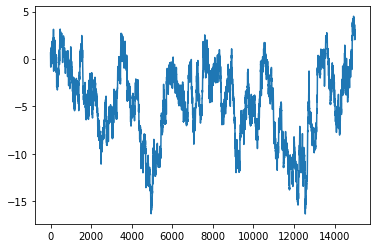

In [7]:
import matplotlib.pyplot as plt
plt.plot(X['C'])

In [8]:
data[0].shape

(14990, 10, 4)

In [9]:
split = 0.8
total_data = data[0].shape[0]
end_ptr = int(total_data*split)

In [10]:
x_train = data[0][:end_ptr]
y_train = data[1][:end_ptr]
x_test = data[0][end_ptr:]
y_test = data[1][end_ptr:]

In [11]:
update_y_train = np.zeros([y_train.shape[0], 3])

for y in range(y_train.shape[0]):
    if y_train[y] < 0.5:
        update_y_train[y][0] = 1
        update_y_train[y][1] = 0
        update_y_train[y][2] = 0
    elif y_train[y] > 0.5:
        update_y_train[y][0] = 0
        update_y_train[y][1] = 0
        update_y_train[y][2] = 1
    else:
        update_y_train[y][0] = 0
        update_y_train[y][1] = 1
        update_y_train[y][2] = 0

In [12]:
update_y_test = np.zeros([y_test.shape[0], 3])

for y in range(y_test.shape[0]):
    if y_test[y] < 0.5:
        update_y_test[y][0] = 1
        update_y_test[y][1] = 0
        update_y_test[y][2] = 0
    elif y_test[y] > 0.5:
        update_y_test[y][0] = 0
        update_y_test[y][1] = 0
        update_y_test[y][2] = 1
    else:
        update_y_test[y][0] = 0
        update_y_test[y][1] = 1
        update_y_test[y][2] = 0

In [13]:
x_train[0]

array([[-0.02853723,  0.64878457, -0.02853723,  0.64870813],
       [ 0.65077136,  0.65128955,  0.1297499 ,  0.21646594],
       [ 0.20940497,  0.59125507,  0.20940497,  0.59125507],
       [ 0.60781908,  0.7313557 ,  0.43510172,  0.6219866 ],
       [ 0.66731357,  0.69737864,  0.336239  ,  0.41274084],
       [ 0.45380319,  0.62030118,  0.25414714,  0.44281711],
       [ 0.45164187,  0.63883869,  0.03423878,  0.08591856],
       [ 0.08233198,  0.13997938, -0.29627098, -0.28028889],
       [-0.27061304, -0.07027717, -0.86370229, -0.78573828],
       [-0.85718401, -0.39971598, -0.86620108, -0.44848621]])

In [14]:
max_features = 4
maxlen = 10
batch_size = 32
y_train = np.array(update_y_train)
y_test = np.array(update_y_test)

In [15]:
x_train.shape

(11992, 10, 4)

# Model

In [16]:
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(maxlen,max_features)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))

model.add(Dense(3, activation='sigmoid'))

# try using different optimizers and different optimizer configs
adam = Adam(lr=1e-4)
model.compile(adam, 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=[x_test, y_test])

Train...
Train on 11992 samples, validate on 2998 samples
Epoch 1/10
11992/11992 [==============================] - 11s 885us/step - loss: 0.5501 - accuracy: 0.6563 - val_loss: 0.5004 - val_accuracy: 0.7319
Epoch 2/10
11992/11992 [==============================] - 8s 663us/step - loss: 0.4968 - accuracy: 0.7060 - val_loss: 0.4886 - val_accuracy: 0.7062
Epoch 3/10
11992/11992 [==============================] - 10s 822us/step - loss: 0.4448 - accuracy: 0.7830 - val_loss: 0.4042 - val_accuracy: 0.8088
Epoch 4/10
11992/11992 [==============================] - 9s 789us/step - loss: 0.3493 - accuracy: 0.8457 - val_loss: 0.3853 - val_accuracy: 0.8262
Epoch 5/10
11992/11992 [==============================] - 9s 761us/step - loss: 0.3281 - accuracy: 0.8661 - val_loss: 0.3490 - val_accuracy: 0.8447
Epoch 6/10
11992/11992 [==============================] - 9s 750us/step - loss: 0.3164 - accuracy: 0.8731 - val_loss: 0.3470 - val_accuracy: 0.8433
Epoch 7/10
11992/11992 [============================

# Validate

In [38]:
n=2

In [39]:
pred = np.argmax(model.predict(x_test[n].reshape(1,x_test[0].shape[0], 4)))

In [40]:
map_dict={'0':'neg_corr', '1':'bm', '2':'pos_corr'}

In [41]:
map_dict.get(str(pred))

'neg_corr'

In [42]:
x_test[n]

array([[ -9.55249179,  -9.52839041,  -9.82260196,  -9.82260196],
       [ -9.8578632 ,  -9.82861865, -10.10379423,  -9.8500697 ],
       [ -9.84837826,  -9.84837826, -10.27287704, -10.08304312],
       [-10.09565137, -10.09565137, -10.45958505, -10.35471034],
       [-10.34173013, -10.0401075 , -10.45201681, -10.26830862],
       [-10.24300457,  -8.40317216, -10.2730699 ,  -8.60172181],
       [ -8.65287576,  -8.08418399,  -8.74747407,  -8.20510459],
       [ -8.18291521,  -8.06716743,  -8.84645359,  -8.51222152],
       [ -8.59597678,  -8.3185064 ,  -9.12142259,  -8.64216352],
       [ -8.71548702,  -8.49906208,  -8.96657133,  -8.96657133]])

In [43]:
assert np.argmax(y_test[n]) == pred, print("Prediction Error")

In [46]:
df[['O', 'H', 'L', 'C']]

,O,H,L,C
0,-0.028537,0.648785,-0.028537,0.648708
1,0.650771,0.651290,0.129750,0.216466
2,0.209405,0.591255,0.209405,0.591255
3,0.607819,0.731356,0.435102,0.621987
4,0.667314,0.697379,0.336239,0.412741
...,...,...,...,...
14995,2.242879,2.737838,2.040534,2.040534
14996,1.931709,2.616066,1.681955,2.249611
14997,2.350050,3.016746,1.979414,2.724233
14998,2.616430,3.059918,1.614615,2.251040
